In [1]:
%tensorflow_version 2.x
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import random
%matplotlib inline

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
print(tf.__version__)

2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Load dataset
names = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/gender_classification/names.csv')
names['Name'] = names['Name'].str.strip()
names['Name'] = names['Name'].str.lower()
names['FirstLetter'] = names['FirstLetter'].str.lower()

In [5]:
names.head(5)

,Name,Gender,LastLetter,LastTwoLetter,FirstLetter
0,ashutosh,1,h,sh,a
1,meghamala,2,a,la,m
2,sahib,1,b,ib,s
3,pragya,2,a,ya,p
4,kranti,2,i,ti,k


# Naive Bayes on the last letter

In [0]:
last_letter = names.LastLetter.values

In [0]:
labels = names.Gender.values

In [0]:
def naive_bayes_classifier(features, labels):
  # Split the data into a training and test set.
  X_train, X_test, y_train, y_test = train_test_split(features.reshape(-1, 1), 
                                                      labels.reshape(-1, 1).ravel(), 
                                                      test_size = 0.3,
                                                      stratify = labels)

  encoder = OneHotEncoder(handle_unknown='ignore')
  X_train = encoder.fit_transform(X_train)
  X_test = encoder.transform(X_test)

  nb_clf = MultinomialNB()

  # Fit the model on the trainng data.
  nb_clf.fit(X_train, y_train)

  # Print the accuracy from the training data.
  print('The mean accuracy on the given train data and labels = ' + 
        str(nb_clf.score(X_train, y_train)))

  # Print the accuracy from the testing data.
  print('The mean accuracy on the given test data and labels = ' + 
        str(nb_clf.score(X_test, y_test)))

  print('Precision: %.3f' 
        %precision_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))
  print('Recall: %.3f' 
        %recall_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))
  print('F1: %.3f' 
        %f1_score(y_true=y_test, y_pred=nb_clf.predict(X_test)))

In [9]:
naive_bayes_classifier(last_letter, labels)

The mean accuracy on the given train data and labels = 0.8229107447413303
The mean accuracy on the given test data and labels = 0.8164347249834327
Precision: 0.897
Recall: 0.738
F1: 0.810


# Naive Bayes on the last two letters

In [0]:
last_two_letters = names.LastTwoLetter.values

In [11]:
naive_bayes_classifier(last_two_letters, labels)

The mean accuracy on the given train data and labels = 0.8334280841387152
The mean accuracy on the given test data and labels = 0.8343273691186216
Precision: 0.872
Recall: 0.805
F1: 0.837


# Naive Bayes on the first letter

In [0]:
first_letter = names.FirstLetter.values

In [13]:
naive_bayes_classifier(first_letter, labels)

The mean accuracy on the given train data and labels = 0.5619670267197271
The mean accuracy on the given test data and labels = 0.5334658714380385
Precision: 0.559
Recall: 0.563
F1: 0.561


# SVM on tfidf vectorized dataset

In [0]:
from sklearn.svm import SVC

def svm_classifier(df):

    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    svm_clf = SVC(C=0.75, kernel='linear')

    # Fit the model on the trainng data.
    svm_clf.fit(X_train, y_train)

    # Print the accuracy from the training data.
    print('The mean accuracy on the given train data and labels = ' + 
          str(svm_clf.score(X_train, y_train)))

    # Print the accuracy from the testing data.
    print('The mean accuracy on the given test data and labels = ' + 
          str(svm_clf.score(X_test, y_test)))
    print('Precision: %.3f' 
          %precision_score(y_true=y_test, 
                           y_pred=svm_clf.predict(X_test)))
    print('Recall: %.3f' 
          %recall_score(y_true=y_test, 
                        y_pred=svm_clf.predict(X_test)))
    print('F1: %.3f' 
          %f1_score(y_true=y_test, 
                    y_pred=svm_clf.predict(X_test)))

In [15]:
svm_classifier(names)

The mean accuracy on the given train data and labels = 0.8769187038089824
The mean accuracy on the given test data and labels = 0.7866136514247847
Precision: 0.788
Recall: 0.816
F1: 0.802


# Train-test split using TfidfVectorizer




In [0]:
def make_tfidf_train_test(df):   

    random.seed(1) 
    
    labels = (df.Gender == 1).values.astype(np.int)
    features = df.Name

    # Using train_test_split() to get train and test datasets from intitial dataset
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    vectorizer = TfidfVectorizer(min_df=0.0, 
                                 analyzer='char', 
                                 ngram_range=(2, 3), 
                                 decode_error='ignore')
  
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()

    ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    ds_valid = ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    input_shape = np.shape(X_train)[1]
    ds_train_len = len(X_train)

    return ds_train, ds_valid, ds_test, input_shape    

In [0]:
tfidf_train_orig, tfidf_valid_orig, tfidf_test, tfidf_input_shape = make_tfidf_train_test(names)

# Train-test split using integer encoding

In [0]:
import string

def get_integer(x):
    chars = list(string.ascii_lowercase)
    ints = list(range(1,27))
    chars_ints_dict = dict(zip(chars, ints)) 

    return chars_ints_dict.get(x)   

In [0]:
def char2sequence_mapping(data):
    
    data['name_sequence'] = data['Name'].apply(lambda name: list( map(get_integer,name)))
    
    #Truncating length of names to length of 26
    rnn_data_features = np.array(pd.DataFrame(data.name_sequence.tolist()).fillna(0))
    rnn_data_features = rnn_data_features[:,:26]

    return rnn_data_features

In [0]:
rnn_features = char2sequence_mapping(names)

In [0]:
def make_rnn_train_test(df, features):   

    random.seed(1) 
    
    labels = (df.Gender == 1).values.astype(np.int)

    # Using train_test_split() to get train and test datasets from intitial dataset
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels.reshape(-1, 1).ravel(), 
                                                        test_size = 0.3,
                                                        stratify = labels)

    ds_train_valid = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train_valid.take(int(0.7 * np.shape(X_train)[0]))
    ds_valid = ds_train_valid.skip(int(0.7 * np.shape(X_train)[0]))
    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    input_shape = np.shape(X_train)[1]
    ds_train_len = len(X_train)

    return ds_train, ds_valid, ds_test, input_shape

In [0]:
rnn_train_orig, rnn_valid_orig, rnn_test, rnn_input_shape = make_rnn_train_test(names,rnn_features)

In [118]:
train_size = 0
for example in rnn_train_orig:
    train_size += 1
print(train_size)

valid_size = 0
for example in rnn_valid_orig:
    valid_size += 1
print(valid_size)

test_size = 0
for example in rnn_test:
    test_size += 1
print(test_size)

2462
1056
1509


# Function for fitting neural network model

In [0]:
def fitting_neural_network(model, batch, epochs, ds_train_orig, ds_valid_orig):
    
    num_epochs = epochs
    batch_size = batch
    steps_train = np.ceil(train_size / batch_size)
    steps_valid = np.ceil(valid_size / batch_size)

    ds_train = ds_train_orig.shuffle(buffer_size=train_size)
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(batch_size=batch_size)
    ds_train = ds_train.prefetch(buffer_size=1000)

    ds_valid = ds_valid_orig.shuffle(buffer_size=valid_size)
    ds_valid = ds_valid.repeat()
    ds_valid = ds_valid.batch(batch_size=batch_size)
    ds_valid = ds_valid.prefetch(buffer_size=1000)

    history = model.fit(ds_train, 
                        epochs=num_epochs, 
                        steps_per_epoch=steps_train, 
                        validation_data = ds_valid, 
                        validation_steps = steps_valid)
    return history

# Function for plotting model train-validation history 

In [0]:
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

# Multilayer perceptron

In [74]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected1', 
                          input_shape=(tfidf_input_shape,)),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout1'),
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected2'),
    tf.keras.layers.Dropout(rate = 0.9,
                            name='dropout2'),
    tf.keras.layers.Dense(150, 
                          activation='relu', 
                          name='fully_connected3'),
    tf.keras.layers.Dense(2, 
                          name='output', 
                          activation='sigmoid')])

mlp_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fully_connected1 (Dense)     (None, 150)               410700    
_________________________________________________________________
dropout1 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected2 (Dense)     (None, 150)               22650     
_________________________________________________________________
dropout2 (Dropout)           (None, 150)               0         
_________________________________________________________________
fully_connected3 (Dense)     (None, 150)               22650     
_________________________________________________________________
output (Dense)               (None, 2)                 302       
Total params: 456,302
Trainable params: 456,302
Non-trainable params: 0
________________________________________________

In [0]:
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [76]:
mlp_hist = fitting_neural_network(mlp_model, batch = 4, epochs = 10, ds_train_orig=tfidf_train_orig, ds_valid_orig=tfidf_valid_orig)

Train for 616.0 steps, validate for 264.0 steps
Epoch 1/10
616/616 [==============================] - 3s 5ms/step - loss: 0.6936 - accuracy: 0.5304 - val_loss: 0.6921 - val_accuracy: 0.5047
Epoch 2/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6929 - accuracy: 0.5394 - val_loss: 0.6902 - val_accuracy: 0.5047
Epoch 3/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6888 - accuracy: 0.5357 - val_loss: 0.6885 - val_accuracy: 0.5616
Epoch 4/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6787 - accuracy: 0.5726 - val_loss: 0.6869 - val_accuracy: 0.5407
Epoch 5/10
616/616 [==============================] - 2s 4ms/step - loss: 0.6656 - accuracy: 0.6144 - val_loss: 0.6705 - val_accuracy: 0.6231
Epoch 6/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6408 - accuracy: 0.6506 - val_loss: 0.6617 - val_accuracy: 0.5994
Epoch 7/10
616/616 [==============================] - 3s 4ms/step - loss: 0.6293 - accuracy: 0.6644 

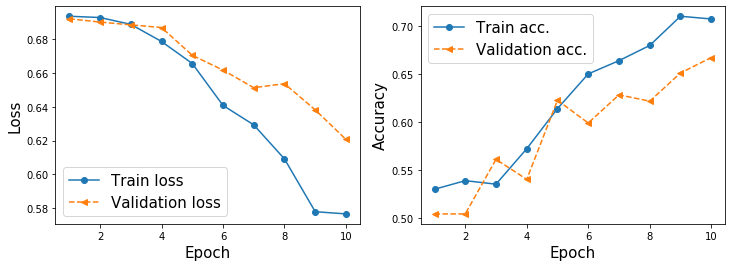

In [77]:
plot_train_valid(mlp_hist)

In [78]:
mlp_results = mlp_model.evaluate(tfidf_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*mlp_results))

1/1 [==============================] - 0s 44ms/step - loss: 0.6309 - accuracy: 0.6428
Test loss: 0.6309   Test Acc.: 0.6428


# Bidirectional with LSTM layer.

In [124]:
embedding_dim = 26
vocab_size = rnn_input_shape + 2

bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             name='lstm-layer'),
                             name='bidir-lstm'), 

    tf.keras.layers.Dense(100, 
                          activation='relu'),
    
    tf.keras.layers.Dense(2, 
                          activation = 'softmax',
                          name = 'output')
])

bi_lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 26)          728       
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 200)               101600    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
output (Dense)               (None, 2)                 202       
Total params: 122,630
Trainable params: 122,630
Non-trainable params: 0
_________________________________________________________________


In [0]:
bi_lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [126]:
bi_lstm_hist = fitting_neural_network(bi_lstm_model, batch=8, epochs=10, ds_train_orig=rnn_train_orig, ds_valid_orig=rnn_valid_orig)

Train for 308.0 steps, validate for 132.0 steps
Epoch 1/10
308/308 [==============================] - 6s 18ms/step - loss: 0.6656 - accuracy: 0.5929 - val_loss: 0.5656 - val_accuracy: 0.7140
Epoch 2/10
308/308 [==============================] - 3s 10ms/step - loss: 0.5506 - accuracy: 0.7411 - val_loss: 0.4921 - val_accuracy: 0.7945
Epoch 3/10
308/308 [==============================] - 3s 10ms/step - loss: 0.4570 - accuracy: 0.8214 - val_loss: 0.4273 - val_accuracy: 0.8248
Epoch 4/10
308/308 [==============================] - 3s 11ms/step - loss: 0.4078 - accuracy: 0.8340 - val_loss: 0.4301 - val_accuracy: 0.8248
Epoch 5/10
308/308 [==============================] - 3s 10ms/step - loss: 0.4003 - accuracy: 0.8405 - val_loss: 0.4009 - val_accuracy: 0.8438
Epoch 6/10
308/308 [==============================] - 3s 10ms/step - loss: 0.3966 - accuracy: 0.8438 - val_loss: 0.4155 - val_accuracy: 0.8333
Epoch 7/10
308/308 [==============================] - 3s 10ms/step - loss: 0.3792 - accuracy: 

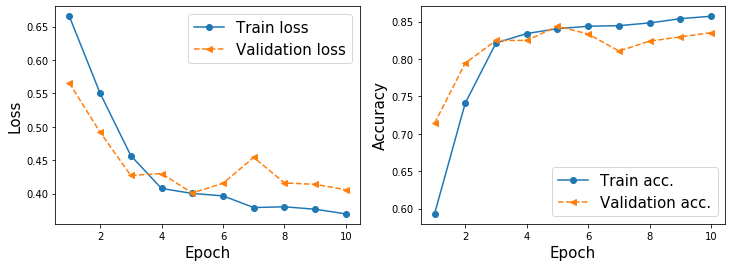

In [127]:
plot_train_valid(bi_lstm_hist)

In [128]:
# evaluate bi_lstm_model on the test data
bi_lstm_results = bi_lstm_model.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*bi_lstm_results))

1/1 [==============================] - 0s 17ms/step - loss: 0.3766 - accuracy: 0.8509
Test loss: 0.3766   Test Acc.: 0.8509


# Bidirectional LSTM with multiple dropout payers.

In [89]:
embedding_dim = 26
vocab_size = rnn_input_shape + 2

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim),
    tf.keras.layers.Dense(100,
                          input_shape=(rnn_input_shape,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, 
                          activation='softmax')
])

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 26)          728       
_________________________________________________________________
dense_4 (Dense)              (None, None, 100)         2700      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)             

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [91]:
model_hist = fitting_neural_network(model, batch=8, epochs=10, ds_train_orig=rnn_train_orig, ds_valid_orig=rnn_valid_orig)

Train for 308.0 steps, validate for 132.0 steps
Epoch 1/10
308/308 [==============================] - 10s 32ms/step - loss: 0.6511 - accuracy: 0.5986 - val_loss: 0.6239 - val_accuracy: 0.6723
Epoch 2/10
308/308 [==============================] - 5s 18ms/step - loss: 0.4860 - accuracy: 0.7934 - val_loss: 0.4265 - val_accuracy: 0.8201
Epoch 3/10
308/308 [==============================] - 5s 16ms/step - loss: 0.4301 - accuracy: 0.8178 - val_loss: 0.4341 - val_accuracy: 0.8248
Epoch 4/10
308/308 [==============================] - 5s 17ms/step - loss: 0.4144 - accuracy: 0.8259 - val_loss: 0.4204 - val_accuracy: 0.8182
Epoch 5/10
308/308 [==============================] - 5s 18ms/step - loss: 0.3983 - accuracy: 0.8369 - val_loss: 0.4103 - val_accuracy: 0.8277
Epoch 6/10
308/308 [==============================] - 5s 17ms/step - loss: 0.3875 - accuracy: 0.8425 - val_loss: 0.4174 - val_accuracy: 0.8277
Epoch 7/10
308/308 [==============================] - 5s 17ms/step - loss: 0.3836 - accuracy:

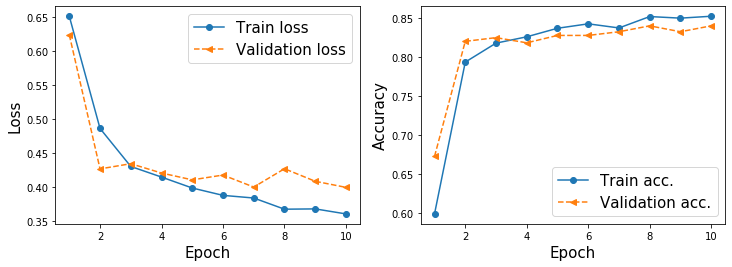

In [92]:
plot_train_valid(model_hist)

In [93]:
# evaluate model on the test data
model_results = model.evaluate(rnn_test.batch(test_size))
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*model_results))

1/1 [==============================] - 0s 36ms/step - loss: 0.3713 - accuracy: 0.8509
Test loss: 0.3713   Test Acc.: 0.8509
